In this task, you are provided with a set of train images that consist of icons
of objects. The set of icons in the training image are provided as shown in
figure 2. In this task you will implement algorithms for matching images,
similar to the principle of playing Dobble.

Output: Detect objects in the Test images, recognize to which class (from
the 50 Training image classes) they belong, and identify their bounding boxes.
One example of a test image is provided in figure 3. For visually demonstrating this, the function should open a box around each detected object and
indicate its class label. Demonstrate example images(s) of the outcome detection in your report.

Evaluate your algorithm on all Test images and report the overall False
Positive (FPR), True Positive (TPR) and accuracy (ACC) rates, and the
4
average runtime. Show and explain cases where this scheme finds difficulty to
perform correctly. Give insight about the complexity (memory and runtime)
of your algorithm in terms of the problem size e.g. how does the complexity
scale in terms of the number of image pixels, pyramid scales?

Creating scaled templates: You should create a Gaussian pyramid of
appropriate scale levels for each RGB Training image. This task includes
implementing appropriate Gaussian blurs and subsampling of the training
images through a hierarchy. You may use your own convolution algorithm
to apply the Gaussian blur, or you may use the library function. In your
report please explain the steps you take to build your Gaussian pyramids
and visually demonstrate an example pyramid for a Training image.

After creating scaled templates, you should append this set by creating
Gaussian pyramids for an appropriate number of orientations per class. This
creates the overall scaled and rotated templates. Justify your choice of parameters (e.g. Gaussian kernel specs, initial/final scales, number of scale
levels e.g. how many octaves, number of rotations etc). To justify quantitatively the chosen number of scales, plot or tabulate the overall object detection performance against these parameters and pick parameters that achieve
a reasonably good runtime vs. accuracy trade off. Evaluate your algorithm
on all Test images to report the overall Intersection over Union (IoU), False
Positive (FPR), True Positive (TPR) and Accuracy (ACC) rates, as well as
the average runtime. Refer to the following report http://host.robots.
ox.ac.uk/pascal/VOC/voc2012/devkit_doc.pdf section 4.4 for further information about the evaluation metrics.

Pre-processing: For each (scaled) template set the background to zero,
similarly for the Test data. Intensity-based matching (related to output 2):
Slide each (scaled and rotated) template over the Test image to measure
their similarities across x-y axes. An intensity-based similarity score based
matching function. Explain why this function is suitable to measure image
similarities? Define appropriate thresholds on this similarity score, a proper
non-maxima suppression strategy to avoid false positives within the neighbourhood of the detected objects and return the output in terms of class
label and bounding box: [left top right bottom] for each object.

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path
from copy import copy
import task2

In [1]:
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"))
(classname, template_pyr) = next(templates)
for i, layer in enumerate(template_pyr):
    # plt.imshow(cv2.cvtColor(layer, cv2.COLOR_GRAY2RGB)), plt.title(f"{classname} | layer {i}"), plt.show()

SyntaxError: incomplete input (2979043150.py, line 4)

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '08-courthouse', '35-police', '45-museum', '50-cemetery']
Accuracy: 0.8
True positive rate: 0.8
False positive rate: 0.0
False negative rate: 0.2 


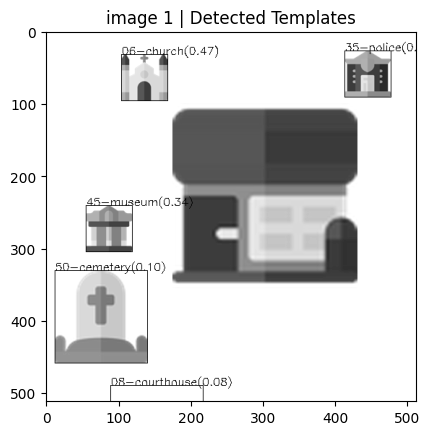

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['03-bridge-1', '20-atm', '50-cemetery']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


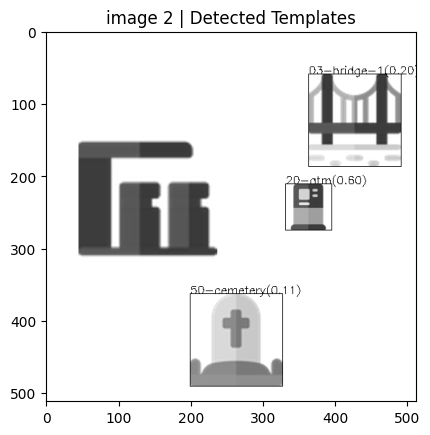

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['05-silo', '10-bench', '19-prison', '31-field', '50-cemetery']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


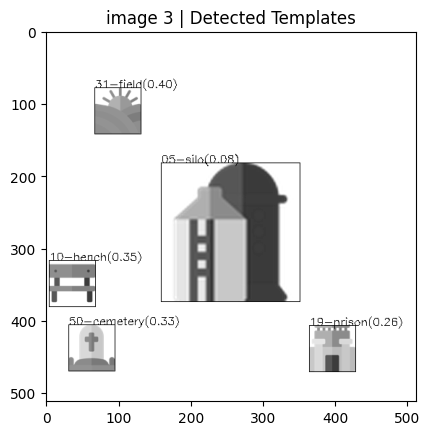

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['01-lighthouse', '03-bridge-1', '18-bank', '21-solar-panel']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


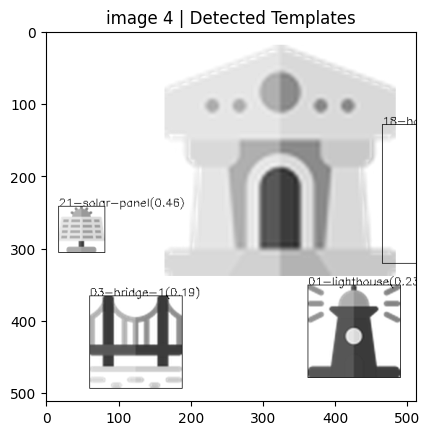

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['11-trash', '19-prison', '33-hydrant']
Accuracy: 0.25
True positive rate: 0.25
False positive rate: 0.0
False negative rate: 0.75 


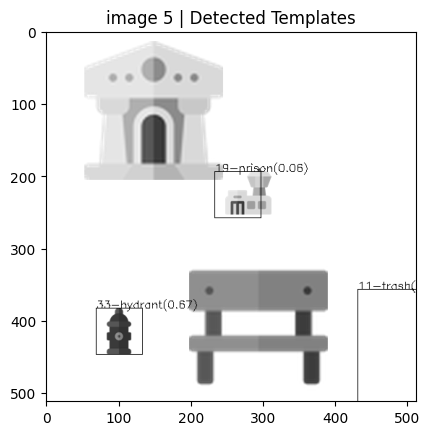

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['11-trash', '20-atm', '25-factory', '28-government']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


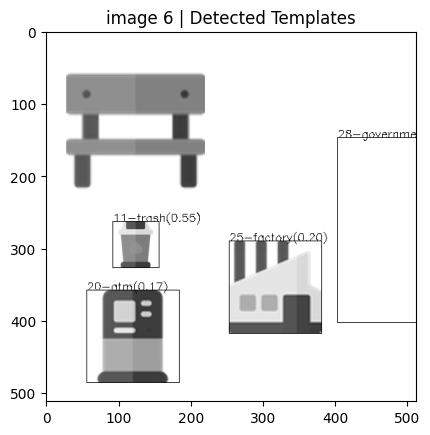

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '07-supermarket', '37-post-office', '38-library', '43-sign']
Accuracy: 0.8
True positive rate: 0.8
False positive rate: 0.0
False negative rate: 0.2 


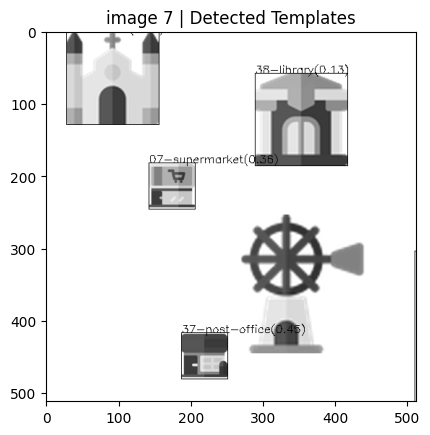

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['01-lighthouse', '05-silo', '09-airport', '45-museum']
Accuracy: 0.75
True positive rate: 1.0
False positive rate: 0.5
False negative rate: 0.0 


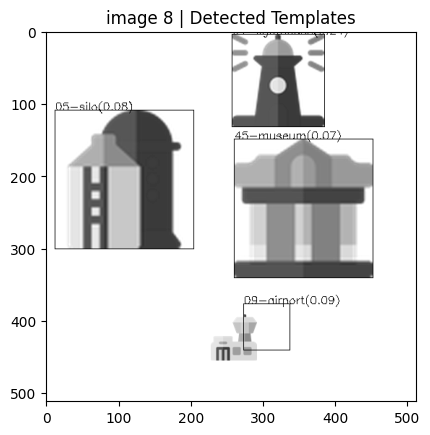

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['07-supermarket', '18-bank', '27-gas-station', '31-field', '34-billboard']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


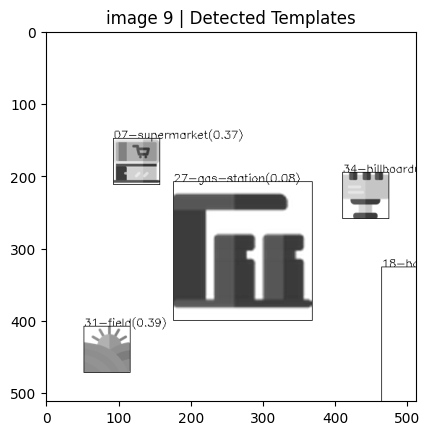

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['08-courthouse', '26-shop', '29-theater']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


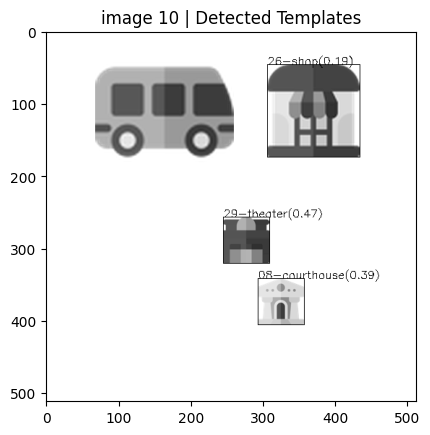

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '11-trash', '24-fountain', '42-tractor']
Accuracy: 0.6
True positive rate: 0.6
False positive rate: 0.0
False negative rate: 0.4 


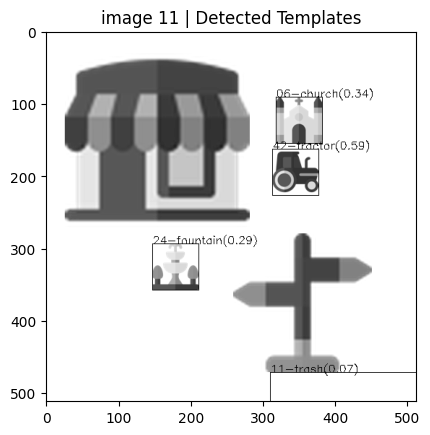

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['04-bridge', '07-supermarket', '28-government', '32-van']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


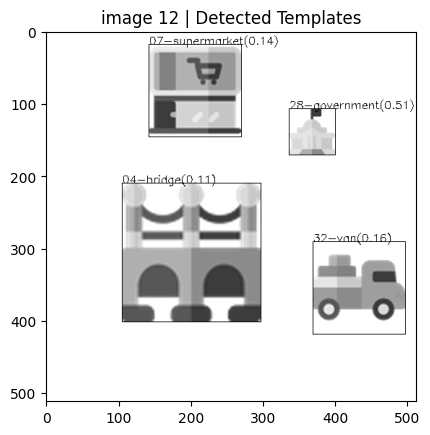

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['08-courthouse', '24-fountain', '27-gas-station', '36-hotel', '42-tractor']
Accuracy: 0.8
True positive rate: 0.8
False positive rate: 0.0
False negative rate: 0.2 


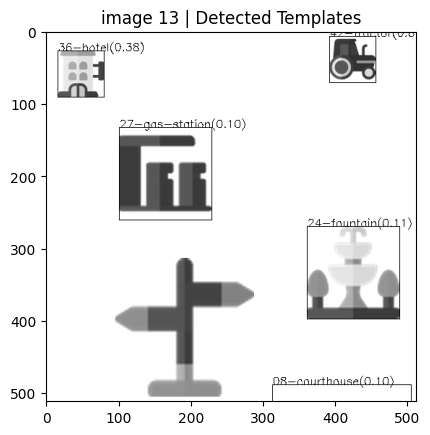

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['03-bridge-1', '06-church', '24-fountain', '25-factory', '43-sign', '49-school']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


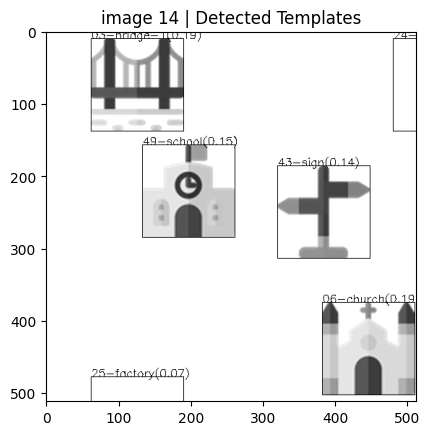

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['07-supermarket', '25-factory', '43-sign', '44-ferris-wheel', '47-restaurant']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


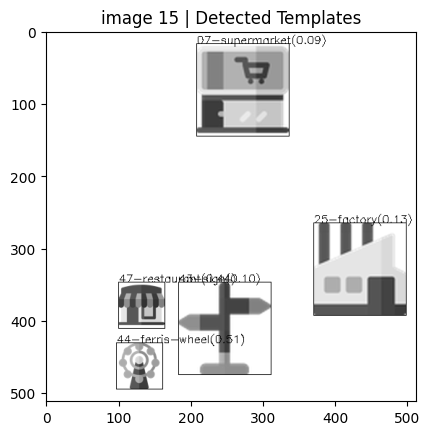

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['06-church', '08-courthouse', '11-trash', '33-hydrant', '37-post-office', '42-tractor']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


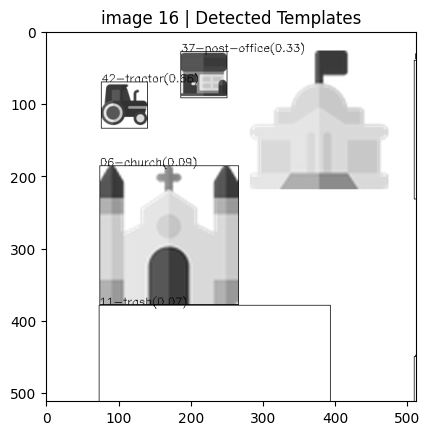

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['15-barn', '20-atm', '21-solar-panel', '33-hydrant']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


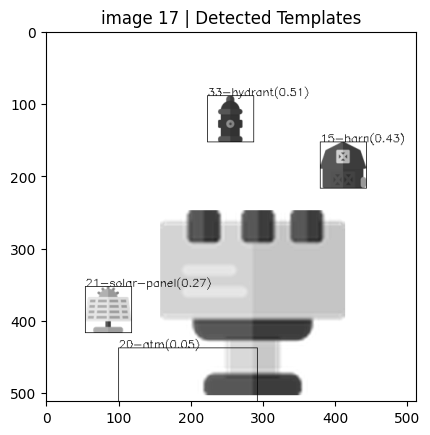

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['20-atm', '28-government', '35-police', '36-hotel']
Accuracy: 1.0
True positive rate: 1.0
False positive rate: 0
False negative rate: 0.0 


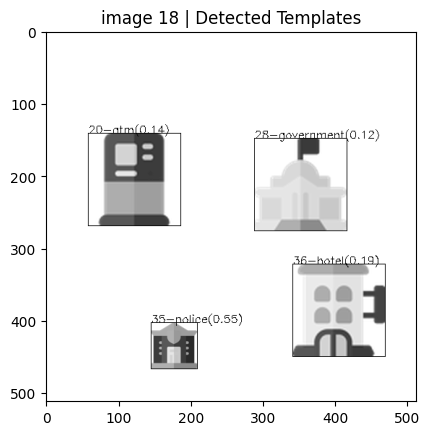

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['01-lighthouse', '06-church', '12-bus', '44-ferris-wheel']
Accuracy: 0.75
True positive rate: 0.75
False positive rate: 0.0
False negative rate: 0.25 


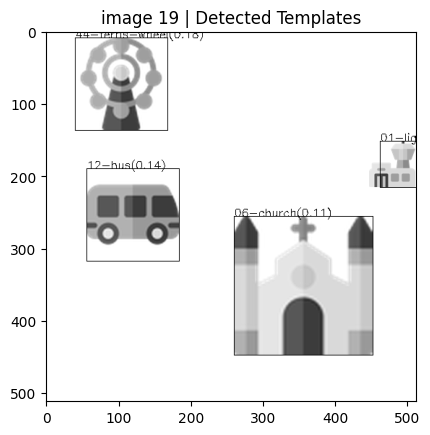

/home/jay/src/computer-vision/task2.py:220: RuntimeWarning: invalid value encountered in divide
  norm_cc_ft = cross_correlation_ft / np.abs(cross_correlation_ft)


Matches: ['23-traffic-light', '43-sign', '46-fire-station']
Accuracy: 0.6
True positive rate: 0.6
False positive rate: 0.0
False negative rate: 0.4 


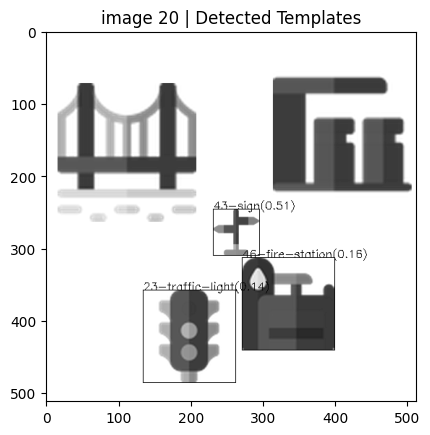

Averave accuracy: 0.7925
Average true positive rate: 0.805
Average false positive rate: 0.025
Average false negative rate: 0.195 


In [23]:

images = task2.images_with_annotations(Path("Task2Dataset"))
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"))
templates = [(classname, pyr) for (classname, pyr) in templates]

# plt.imshow(templates[0][1][0], cmap='gray')
# plt.title(f'template')
# plt.show()

results: list[tuple[float, float, float, float]] = []

for i, (img, annotations) in enumerate(images):
    # img_pyr = task2.gaussian_pyrarmid(img, image_pyramid_levels)

    # image_grayscale = img#cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # _, image_binary = cv2.threshold(image_grayscale, 254, 255, cv2.THRESH_BINARY)
    # mask = cv2.bitwise_not(image_binary)
    # print(img.shape, mask.shape)
    # image_masked = cv2.bitwise_and(img, mask)
    # img = image_masked
    # plt.imshow(image_masked, cmap='gray'), plt.show()

    img_pyr = [img]
    classnames, scores, pred_boxes = task2.predict_all_templates(img_pyr, templates)

    task2.non_max_suppression(pred_boxes, scores, classnames)
    task2.annotate_predictions(img, classnames, scores, pred_boxes)
    metrics = task2.evaluation_metrics(dict(zip(classnames, pred_boxes)), annotations)
    results.append(metrics)

    accuracy, true_pos_rate, false_pos_rate, false_neg_rate = metrics
    print(f"Matches: {classnames}")
    print(f"Accuracy: {accuracy}")
    print(f"True positive rate: {true_pos_rate}")
    print(f"False positive rate: {false_pos_rate}")
    print(f"False negative rate: {false_neg_rate} ")
    
    plt.imshow(img, cmap='gray')
    plt.title(f'image {i+1} | Detected Templates')
    plt.show()
    

average_metrics = [np.mean(values) for values in zip(*results)]
print(f"Averave accuracy: {average_metrics[0]}")
print(f"Average true positive rate: {average_metrics[1]}")
print(f"Average false positive rate: {average_metrics[2]}")
print(f"Average false negative rate: {average_metrics[3]} ")

[0.8, 0.75, 1.0, 0.75, 0.25, 0.75, 0.8, 0.75, 1.0, 0.75, 0.6, 1.0, 0.8, 1.0, 1.0, 0.75, 0.75, 1.0, 0.75, 0.6]
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


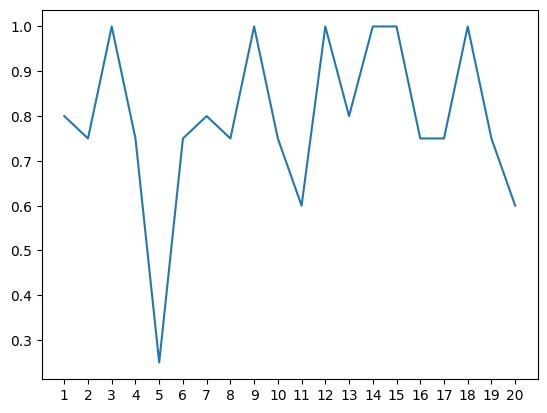

Averave accuracy: 0.7925
Average true positive rate: 0.805
Average false positive rate: 0.025
Average false negative rate: 0.195 


In [21]:
img_names = [f"{i + 1}" for i in range(20)]
accuracy, tpr, fpr, fnr = [list(t) for t in zip(*rotated_images)]
print(list(accuracy))
print(img_names)
plt.plot(img_names, accuracy), plt.show()

average_metrics = [np.mean(values) for values in zip(*rotated_images)]
print(f"Averave accuracy: {average_metrics[0]}")
print(f"Average true positive rate: {average_metrics[1]}")
print(f"Average false positive rate: {average_metrics[2]}")
print(f"Average false negative rate: {average_metrics[3]} ")

Averave accuracy: 0.605
Average true positive rate: 0.725
Average false positive rate: 0.2058333333333333
Average false negative rate: 0.27499999999999997 

opencv matchtemplate


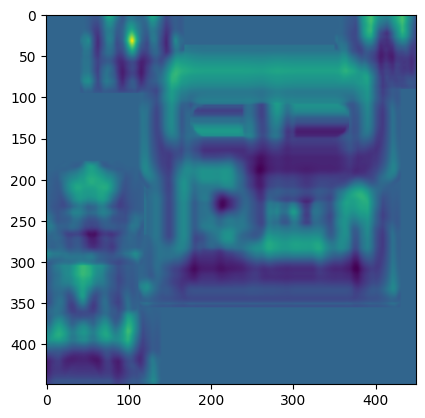

(-0.46739596128463745, 0.9660936594009399, (376, 308), (104, 32))
fft ccoef_normed
aaa (64, 64)
(2, 64)


/home/jay/src/computer-vision/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2486: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  results = func(*(arg[index] for arg in args))


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'minMaxLoc'
> Overload resolution failed:
>  - src is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'src'


In [95]:
num_pyramid_levels = 5
images = task2.images_with_annotations(Path("Task2Dataset"))
templates = task2.template_pyramid_by_classname(Path("IconDataset", "png"))

img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# img, annotations = next(images)
# norm_image = (img - np.mean(img)) / np.std(img)
# plt.imshow(img), plt.show()    
# plt.imshow(norm_image), plt.show()    
    # norm_template = (template - np.mean(template)) / np.std(template)
# plt.imshow(img), plt.show()    
classname, pyr = next(templates)
while classname != "06-church":
    classname, pyr = next(templates)
template = pyr[16]
# plt.imshow(img), plt.show()
# plt.imshow(template), plt.show()

# print("template shape: ", template.shape)
# img_copy = img.copy()
# result_same_size_test = cv2.matchTemplate(img_copy, template, cv2.TM_SQDIFF) # <-- this is not allowed
# print(cv2.minMaxLoc(result_same_size_test))

# multi_scale_template_matching(img, template)

print("opencv matchtemplate")
result = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) # <-- this is not allowed
plt.imshow(result), plt.show()
print(cv2.minMaxLoc(result))

print("fft ccoef_normed")
result_home_grown = task2.normed_cross_correlation(img, template)
print(cv2.minMaxLoc(result_home_grown))
plt.imshow(result_home_grown), plt.show()

# annotated_img = img.copy()
# for (img, annotations) in images:
# task2.predict_all_templates(templates, img, annotations, annotated_img, num_pyramid_levels)
# plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_GRAY2RGB)), plt.show()    